# Comparison to the Water Budget

We want to compare the changes of our reconstructed water storage anomalies to the water balance equation, calculated from ERA5.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar
import numpy as np
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deepwaters  # noqa
from deepwaters import metrics
from deepwaters.regions import basins
from deepwaters.utils import ROOT_DIR
from deepwaters.visualization import plot_basinwise_map

# Register dask progress bar
ProgressBar(minimum=5).register()

In [2]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures"

## Data Loading

For preprocessing, see the corresponding notebook [here](./3.1-water-budget-preprocessing.ipynb).

In [ ]:
twsc_path = ROOT_DIR / "data/evaluations/twsc_basin-scale.zarr"
twsc = xr.open_zarr(twsc_path)

## Analysis

Define evaluation models and water balance target:

In [ ]:
vars_verbose = {
    "pred_ensemble_alltrain_gap_lnll_latest": "DeepWaters (Ours)",
    "pred_ensemble_alltrain_nogap_lnll_latest": "DeepWaters w/ WGHM (Ours)",
    "gap": "WGHM",
    "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "li_csr_full": "Li's CSR Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "csr": "GRACE CSR-M",
}
bdgt_name = "era5_smooth"
grace_name = "csr"
eval_names = vars_verbose.keys()


### RMSE during GRACE-ERA

In [5]:
twsc_post = twsc.where(twsc.dw.time_notnull("region"), drop=True)
twsc_post

<xarray.Dataset> Size: 997kB
Dimensions:                                   (region: 72, time: 192)
Coordinates:
  * region                                    (region) object 576B 'Congo' .....
  * time                                      (time) datetime64[ns] 2kB 2002-...
Data variables:
    csr                                       (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    era5                                      (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    era5_smooth                               (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    gap                                       (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    humphrey_gsfc_detrend                     (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    li_csr_full                               (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    pred_ensemble_alltrain_gap_lnll_latest    (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    pred_ensemble_alltrain_nogap_lnll_latest  (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    yin_csr_full                              (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>

In [ ]:
bdgt_post = twsc_post[bdgt_name]
eval_post = twsc_post[eval_names].to_dataarray("model")

In [7]:
da_post_rmse = metrics.rmse(bdgt_post, eval_post, dim="time").compute()
da_post_rmse.attrs["standard_name"] = "RMSE"
da_post_rmse.attrs["unit"] = "mm / month"

In [8]:
plot_kwargs = dict(
    col_wrap=2,
    coastlines=True,
    gridlines=True,
    cmap="viridis",
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.8, pad=0.03),
    rasterized=True,
    figsize=(6, 8.25),
)
basinlines_kwargs = dict(
    edgecolor="black",
    linewidth=0.5,
    facecolor="None",
    rasterized=True,
)
title_kwargs = dict(fontsize=16, weight="bold")

In [27]:
# Create a spatial dummy array for the plot_basinwise_map() function
STEP_DEG = 0.5
lats = np.arange(-89.75, 89.75 + STEP_DEG, STEP_DEG)
lons = np.arange(-179.75, 179.75 + STEP_DEG, STEP_DEG)
models = eval_post.model.values

ones = np.ones([len(models), len(lats), len(lons)])

spatial_dummy_post = xr.DataArray(
    ones, coords={"model": models, "lat": lats, "lon": lons}
)


In [10]:
# Get timespan
start = eval_post.get_index("time")[0]
end = eval_post.get_index("time")[-1]
timespan_str = f"{start.year}-{start.month:02} - {end.year}-{end.month:02}"
timespan_str

'2002-05 - 2019-06'

In [11]:
print(f"{da_post_rmse.max() = :.2f}")

da_post_rmse.max() = 48.72


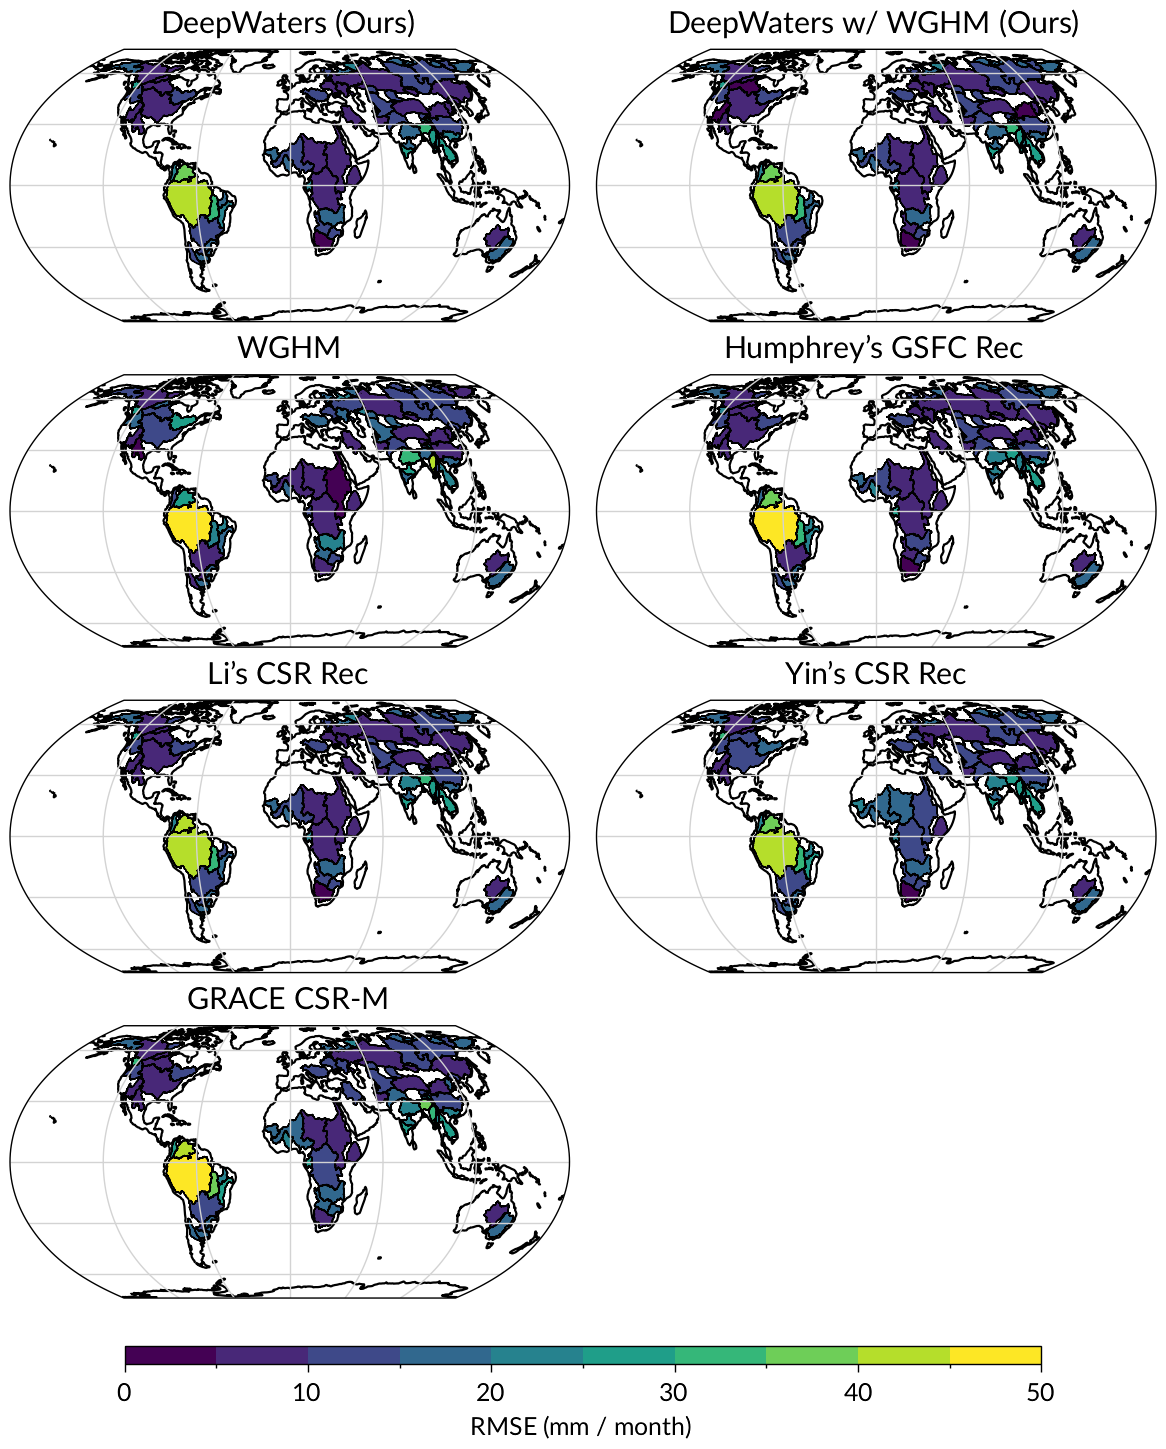

In [12]:
plot_kwargs["cbar_kwargs"]["label"] = "RMSE (mm / month)"

p = plot_basinwise_map(
    da_post_rmse,
    spatial_obj=spatial_dummy_post,
    col="model",
    **plot_kwargs,
    vmin=0,
    vmax=50,
    levels=11,
)

basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, da_post_rmse.model.values):
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)
    ax.set_title(vars_verbose[model])

p.fig.savefig(FIGURE_DIR / "waterbudget_rmse.pdf", backend="pgf")

In [13]:
basin_shapes = basins(top=72)
basin_areas = basin_shapes.set_index(basin_shapes.river.rename("region")).shape_area
area_weights = xr.DataArray.from_series(basin_areas)

In [15]:
rmse_post_avg

model
GRACE CSR-M                  15.244942
Yin's CSR Rec                15.125896
WGHM                         14.320535
Humphrey's GSFC Rec          14.036314
Li's CSR Rec                 13.741069
DeepWaters (Ours)            13.532002
DeepWaters w/ WGHM (Ours)    13.404116
dtype: float64

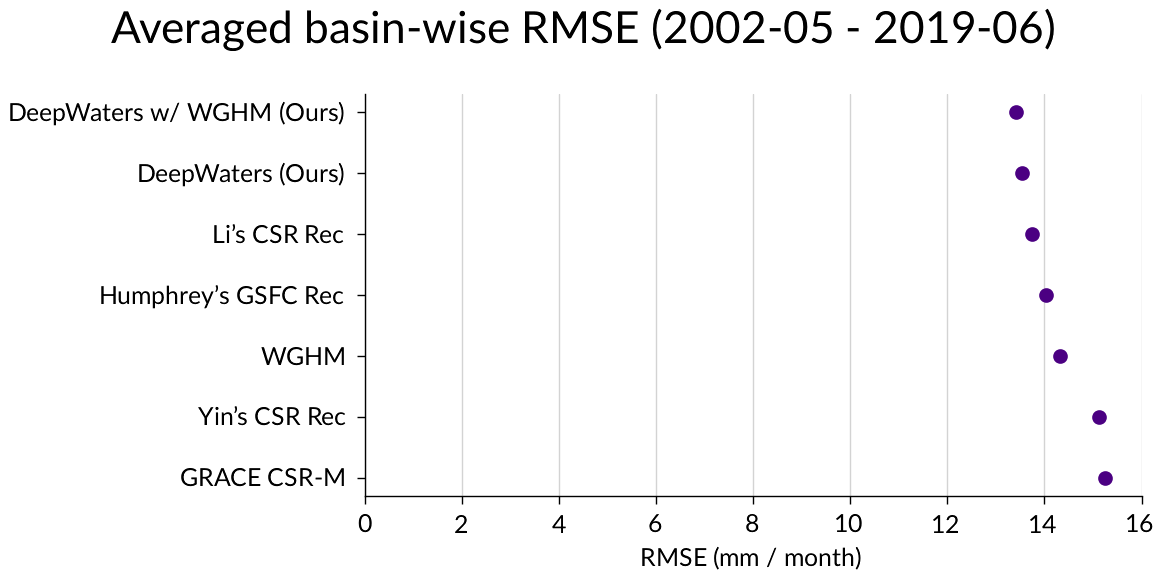

In [22]:
rmse_post_avg = (
    da_post_rmse.weighted(area_weights)
    .mean("region")
    .to_pandas()
    .sort_values(ascending=False)
    .rename(vars_verbose)
    .reset_index(name="rmse")
)

ax = rmse_post_avg.plot.scatter(figsize=(6, 3), x="rmse", y="model", color="indigo")
ax.set(xlabel="RMSE (mm / month)", ylabel=None, xlim=(0, 16))
ax.xaxis.grid()
ax.figure.suptitle(f"Averaged basin-wise RMSE ({timespan_str})", **title_kwargs);

### NSE during GRACE era

In [23]:
da_pre_nse = metrics.nse(bdgt_post, eval_post, dim="time").compute()
da_pre_nse.attrs["standard_name"] = "NSE"
da_pre_nse.attrs["unit"] = "-"

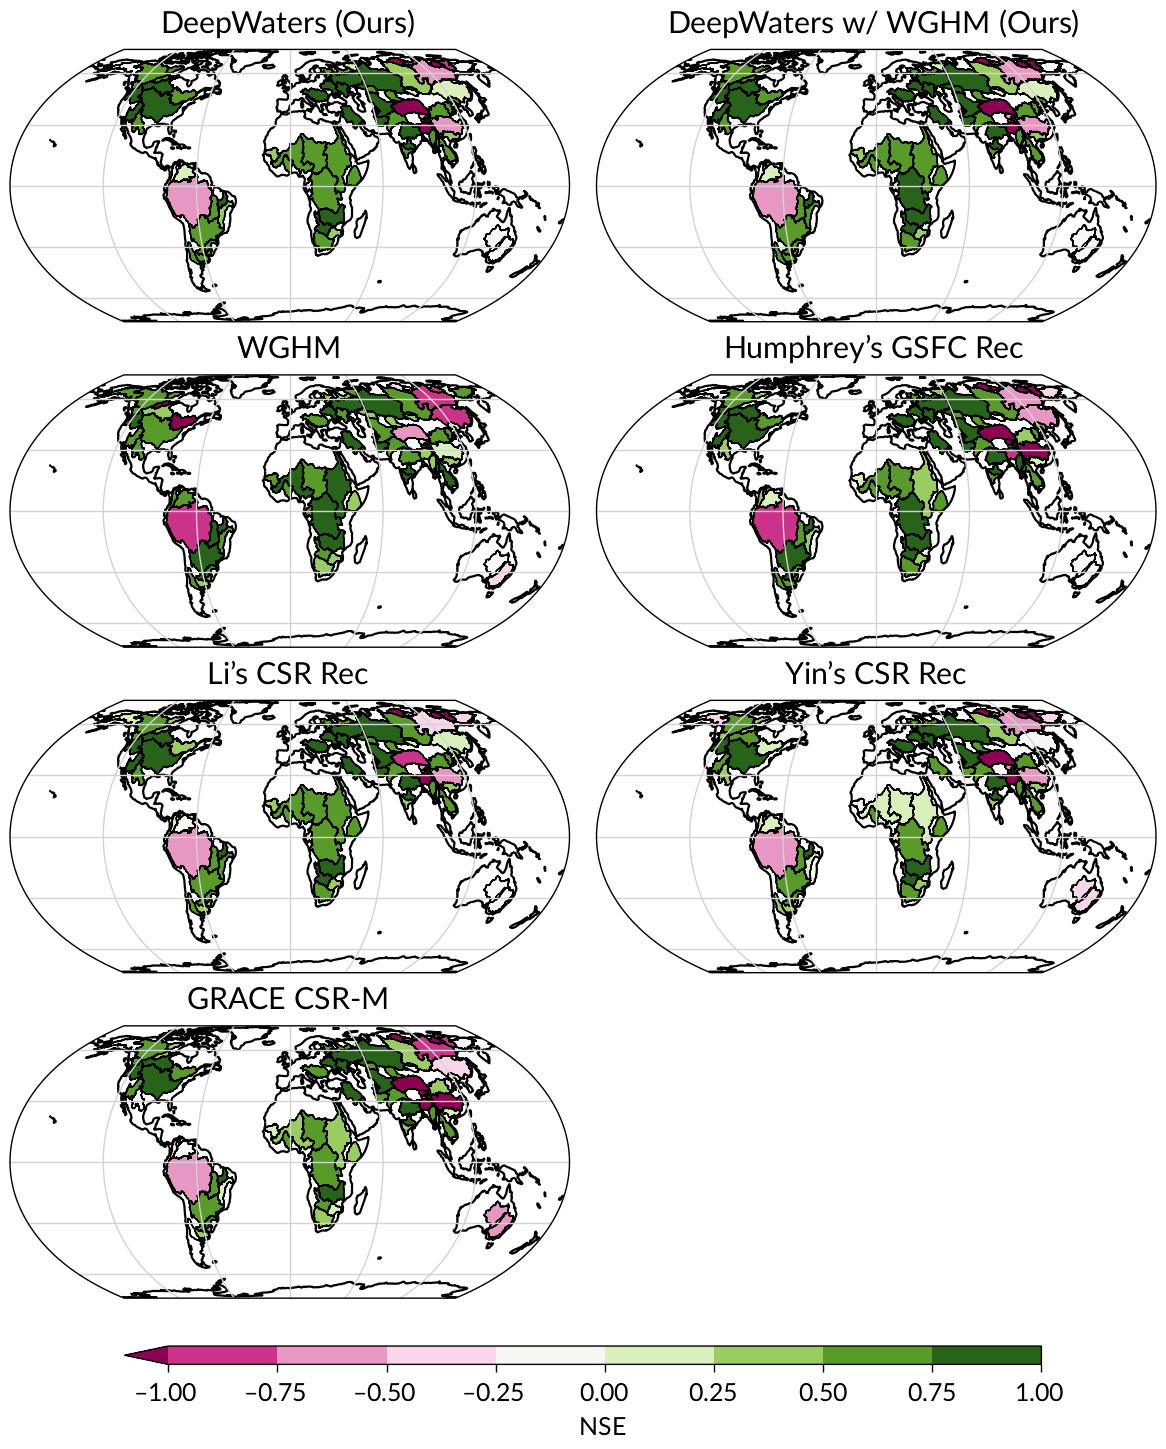

In [24]:
plot_kwargs["cmap"] = "PiYG"
plot_kwargs["cbar_kwargs"]["label"] = "NSE"

p = plot_basinwise_map(
    da_pre_nse,
    spatial_obj=spatial_dummy_post,
    col="model",
    **plot_kwargs,
    vmin=-1,
    vmax=1,
    levels=9,
)

basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, da_pre_nse.model.values):
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)
    ax.set(title=vars_verbose[model])

p.fig.savefig(FIGURE_DIR / "waterbudget_nse.pdf", backend="pgf")

Average the basins according to their area:

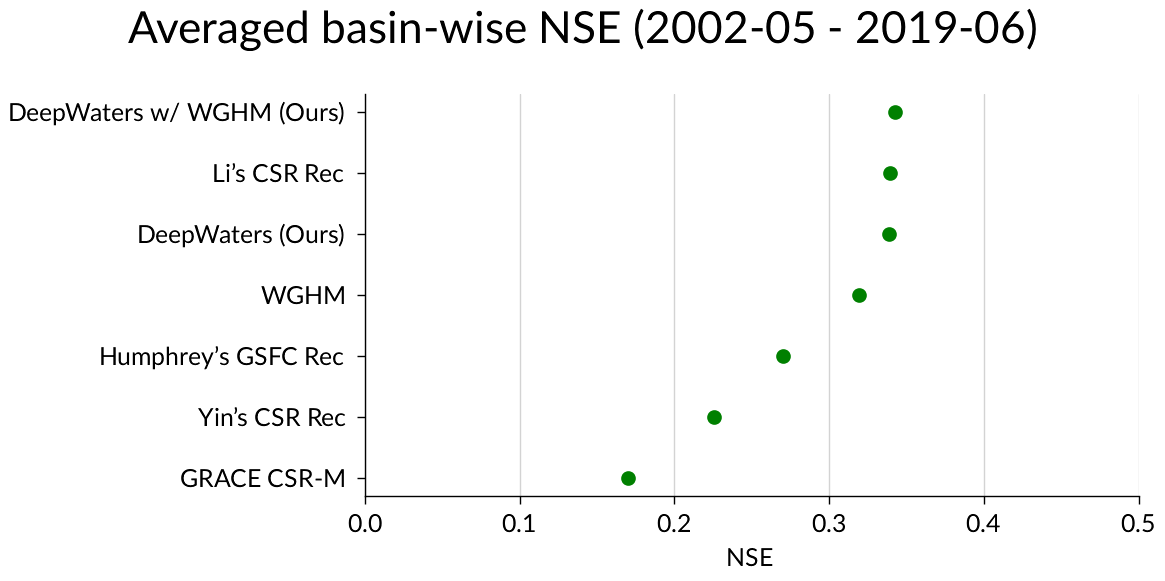

In [ ]:
nse_post_avg = (
    da_pre_nse.weighted(area_weights)
    .mean("region")
    .to_pandas()
    .sort_values()
    .rename(vars_verbose)
    .reset_index(name="nse")
)

ax = nse_post_avg.plot.scatter(figsize=(6, 3), x="nse", y="model", color="green")
ax.xaxis.grid()
ax.set(xlabel="NSE", ylabel=None, xlim=(0.0, 0.5))
ax.figure.suptitle(f"Averaged basin-wise NSE ({timespan_str})", **title_kwargs);

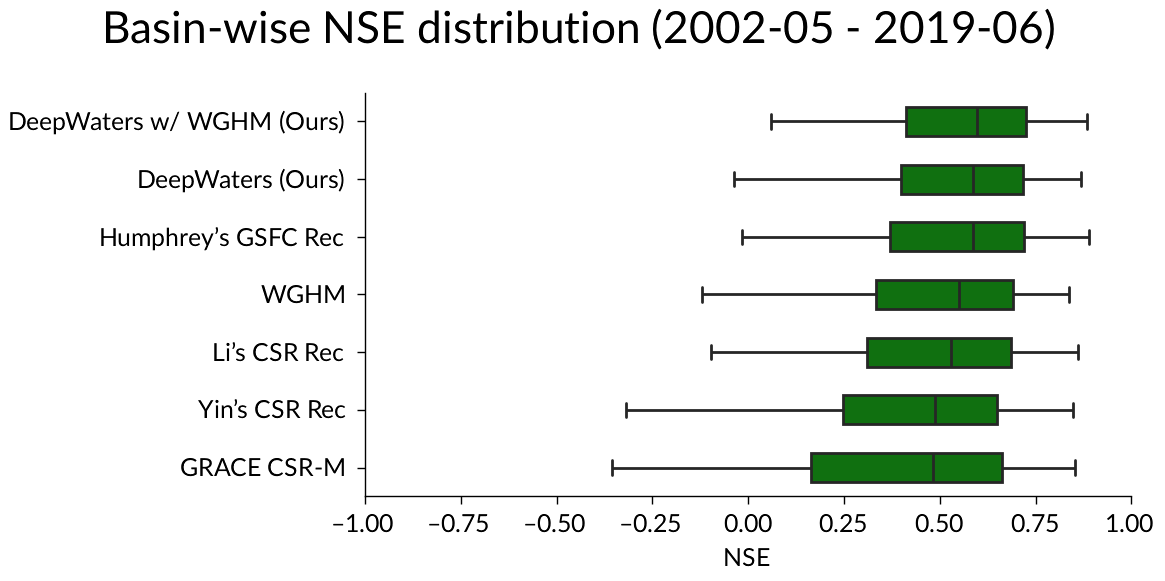

In [ ]:
df_plot = (
    da_pre_nse.to_pandas()
    .reset_index()
    .melt(id_vars="region", var_name="model", value_name="nse")
)
# Sort after median
sorted_models = (
    df_plot.groupby(by=["model"])["nse"].median().sort_values(ascending=False).index
)
df_plot.model = pd.Categorical(
    df_plot.model, categories=sorted_models, ordered=True
).rename_categories(vars_verbose)
fig, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(
    df_plot,
    y="model",
    x="nse",
    color="green",
    showfliers=False,
    width=0.5,
    ax=ax,
)
ax.set(xlabel="NSE", ylabel=None, xlim=(-1.0, 1.0))
ax.figure.suptitle(f"Basin-wise NSE distribution ({timespan_str})", **title_kwargs);

### Cyclostationary NSE during GRACE era

In [ ]:
da_post_nsec = metrics.nsec(bdgt_post, eval_post).compute()
da_post_nsec.attrs["standard_name"] = "NSEC"
da_post_nsec.attrs["unit"] = "-"

[########################################] | 100% Completed | 12.47 s


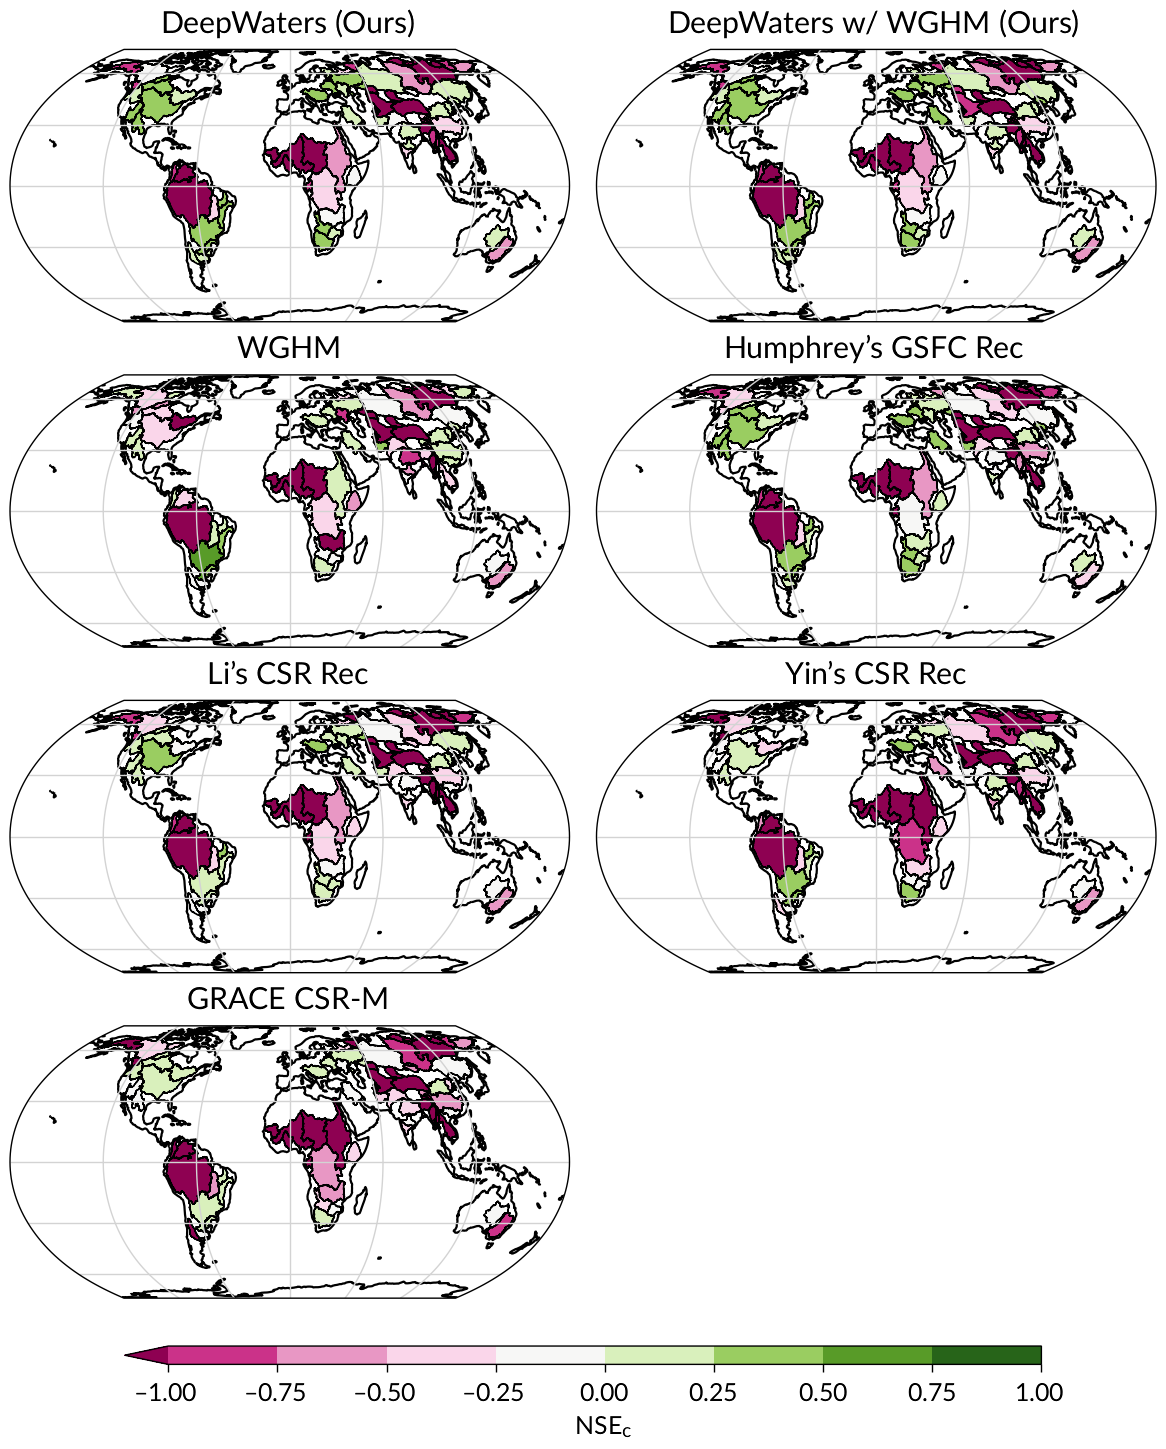

In [ ]:
plot_kwargs["cbar_kwargs"]["label"] = r"NSE$_\text{c}$"

p = plot_basinwise_map(
    da_post_nsec,
    spatial_obj=spatial_dummy_post,
    col="model",
    **plot_kwargs,
    vmin=-1,
    vmax=1,
    levels=9,
)

basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, da_post_nsec.model.values):
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)
    ax.set(title=vars_verbose[model])

p.fig.savefig(FIGURE_DIR / "waterbudget_nsec.pdf", backend="pgf")

### NSE before the GRACE era

In [ ]:
twsc_pre = twsc.sel(time=slice("1980", "2002-03"))

bdgt_pre = twsc_pre[bdgt_name]
eval_pre = twsc_pre[eval_names].drop_vars(grace_name).to_dataarray("model")

spatial_dummy_pre = spatial_dummy_post.drop_sel(model=grace_name)

In [ ]:
da_pre_nse = metrics.nse(bdgt_pre, eval_pre, dim="time").compute()
da_pre_nse.attrs["standard_name"] = "NSE"
da_pre_nse.attrs["unit"] = "-"

In [ ]:
# Get timespan
start = eval_pre.get_index("time")[0]
end = eval_pre.get_index("time")[-1]
timespan_str = f"{start.year}-{start.month:02} - {end.year}-{end.month:02}"
timespan_str

'1980-01 - 2002-03'

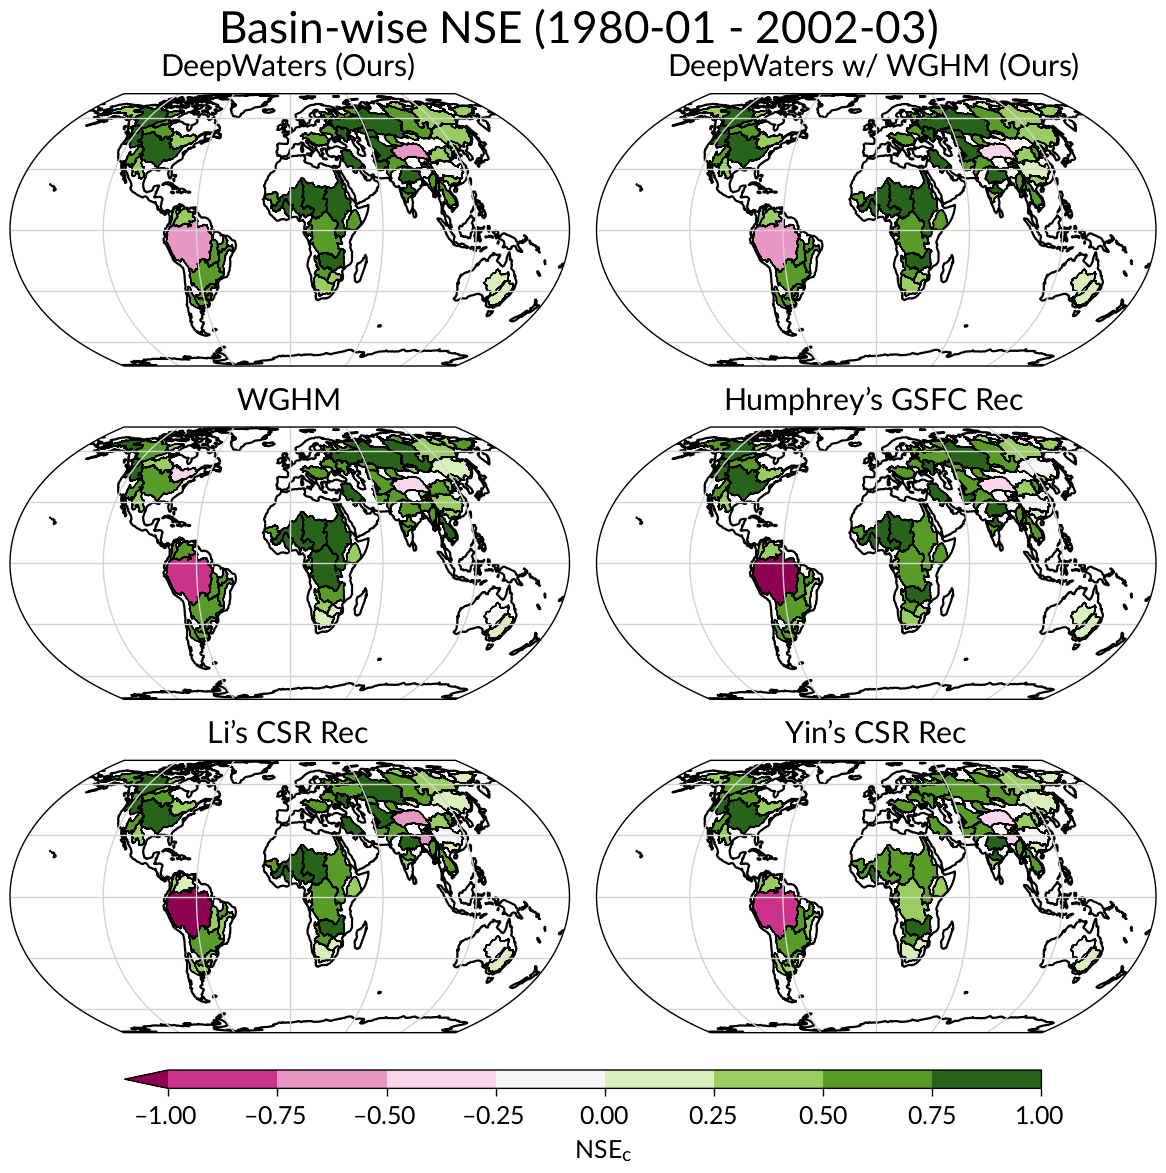

In [ ]:
plot_kwargs["figsize"] = (6, 6.5)
plot_kwargs["col_wrap"] = 2

p = plot_basinwise_map(
    da_pre_nse,
    spatial_obj=spatial_dummy_pre,
    col="model",
    **plot_kwargs,
    vmin=-1,
    vmax=1,
    levels=9,
)

basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, da_pre_nse.model.values):
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)
    ax.set(title=vars_verbose[model])
p.fig.suptitle(f"Basin-wise NSE ({timespan_str})", **title_kwargs);

## NSE decadal chart from 1940 to now

Calculate the NSE per model and decade.

Interpolation of all missing CSR time steps (except during GRACE/-FO gap):

In [ ]:
start = 1940
end = 2020
SEGMENT_LENGTH = 10  # years
nse_list = []

curr_start = start
# Iterate over all time periods
while (curr_end := curr_start + SEGMENT_LENGTH - 1) <= end:
    # Slice to specified duration
    # Timestamps must be strings, end year is inclusive
    twsc_basin_seg = twsc.sel(time=slice(str(curr_start), str(curr_end))).chunk(time=-1)

    bdgt_var = twsc_basin_seg[bdgt_name]
    eval_vars = twsc_basin_seg[eval_names]

    # Remove variables which are NA for most of the time
    n_time = len(eval_vars.time)
    for dvar in eval_vars.data_vars:
        if len(eval_vars[dvar].dropna("time", how="all").time) < 0.5 * n_time:
            eval_vars = eval_vars.drop_vars(dvar)

    # Remove all time steps which are NA for at least one variable
    missing_time = eval_vars.dw.time_notnull("region")
    eval_vars = eval_vars.where(missing_time, drop=True)
    bdgt_var = bdgt_var.where(missing_time, drop=True)

    nse_avg = (
        # Ignore if some values in a particular time series are NA
        metrics.nse(bdgt_var, eval_vars, skipna=True)
        .weighted(area_weights)
        .mean("region")
        .compute()
        .to_pandas()
        .rename(vars_verbose)
        .rename_axis(index="model")
        .reset_index(name="nse")
        # Add time period column
        .assign(time=pd.Timestamp(str(curr_start + SEGMENT_LENGTH // 2)))
    )
    # Add time column

    nse_list.append(nse_avg)

    # Increase start year
    curr_start += SEGMENT_LENGTH

In [ ]:
nse_decadal = pd.concat(nse_list, ignore_index=True)
model_names = list(vars_verbose.values())
model_names.remove("GRACE CSR-M")

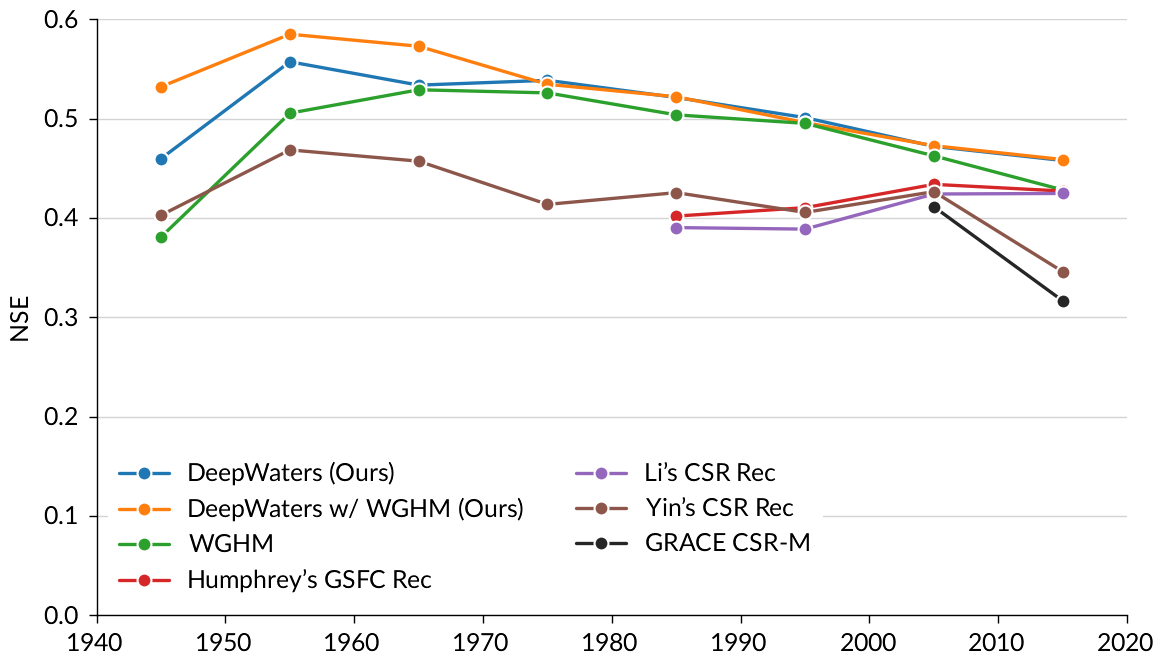

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3.5))

lineplot_kwargs = dict(
    x="time",
    y="nse",
    hue="model",
    marker="o",
    ax=ax,
)
sns.lineplot(
    nse_decadal.query("model != 'GRACE CSR-M'"),
    hue_order=model_names,
    **lineplot_kwargs,
)
sns.lineplot(
    nse_decadal.query("model == 'GRACE CSR-M'"),
    **lineplot_kwargs,
    palette="dark:black",
)
ax.set(
    xlabel=None,
    ylabel="NSE",
    xlim=(pd.Timestamp("1940"), pd.Timestamp("2020")),
    ylim=(0.0, 0.6),
)
ax.yaxis.grid(True)

ax.legend(loc="lower left", ncol=2, title=None, frameon=True)

fig.savefig(FIGURE_DIR / "waterbudget_closure.pdf", backend="pgf")